The goal of this code is to parcel the HCP MMP ROIs to use them as ROIs in Pycortex. For this purpose, you need the Pycortex subject from here: https://figshare.com/articles/dataset/59k_HCP_subject_entry_for_pycortex_database/13372958. You can delete all the areas already present in the ROI shapes.

And the CSV file from here: https://neuroimaging-core-docs.readthedocs.io/en/latest/pages/atlases.html

In [3]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# General imports
import os
import sys
import cortex
from cortex.rois import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Personal imports
sys.path.append("{}/../../utils".format(os.getcwd()))
from surface_utils import load_surface ,make_surface_image
from pycortex_utils import set_pycortex_config_file

In [4]:
# Imputs
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'
pycortex_dir = '{}/{}/derivatives/pp_data/cortex/db/'.format(main_dir,project_dir)
pycortex_subject = 'sub-170k'


We need to create a DataFrame using the .npz file. In the right hemisphere, we have to add 180 because the CSV codes areas are numbered from 0 to 360, while in the .npz file, they are numbered from 1 to 180. Additionally, we need to add 1 to the indices of CSV code to ensure correct correspondence. After verification, we also adjusted the areas code for p24 to maintain accurate correspondence.

In [5]:
# load npz atlas and make dataframe
mmp_atlas_fn ='{}/{}/surface-info/mmp_atlas.npz'.format(pycortex_dir, pycortex_subject)
mmp_npz = np.load(mmp_atlas_fn)

#  make left hemi 
mmp_df_lh = pd.DataFrame(mmp_npz['left'], columns = ['roi_id'])
mmp_df_lh = mmp_df_lh.assign(hemi='L')
 
#  make left hemi 
mmp_df_rh = pd.DataFrame(mmp_npz['right'], columns = ['roi_id'])
mmp_df_rh = mmp_df_rh.assign(hemi='R')


#  make brain df
mmp_df_brain = pd.concat([mmp_df_lh,mmp_df_rh], ignore_index=True )
mmp_df_brain = mmp_df_brain.assign(roi_name=np.nan)

mmp_df_brain['roi_id'] = mmp_df_brain['roi_id'].replace({0: 180})
mmp_df_brain['roi_id_hemi'] = np.where(mmp_df_brain['hemi'] == 'R', mmp_df_brain['roi_id'] + 180, mmp_df_brain['roi_id'])


In [6]:
#  Load csv 
mmp_csv_fn = '{}/{}/HCP-MMP1_UniqueRegionList.csv'.format(pycortex_dir, pycortex_subject)
mmp_csv = pd.read_csv(mmp_csv_fn)
mmp_csv['index_col'] = (mmp_csv.index + 1).astype('int32')

In [7]:
# make the final dataframe with the correpondamce between the code and the areas
mmp_final_df = pd.merge(mmp_df_brain, mmp_csv, left_on='roi_id_hemi', right_on='index_col', how='left')
mmp_final_df = mmp_final_df[['roi_id', 'roi_id_hemi', 'region','hemi']]  
mmp_final_df.rename(columns={'region': 'roi_name'}, inplace=True)

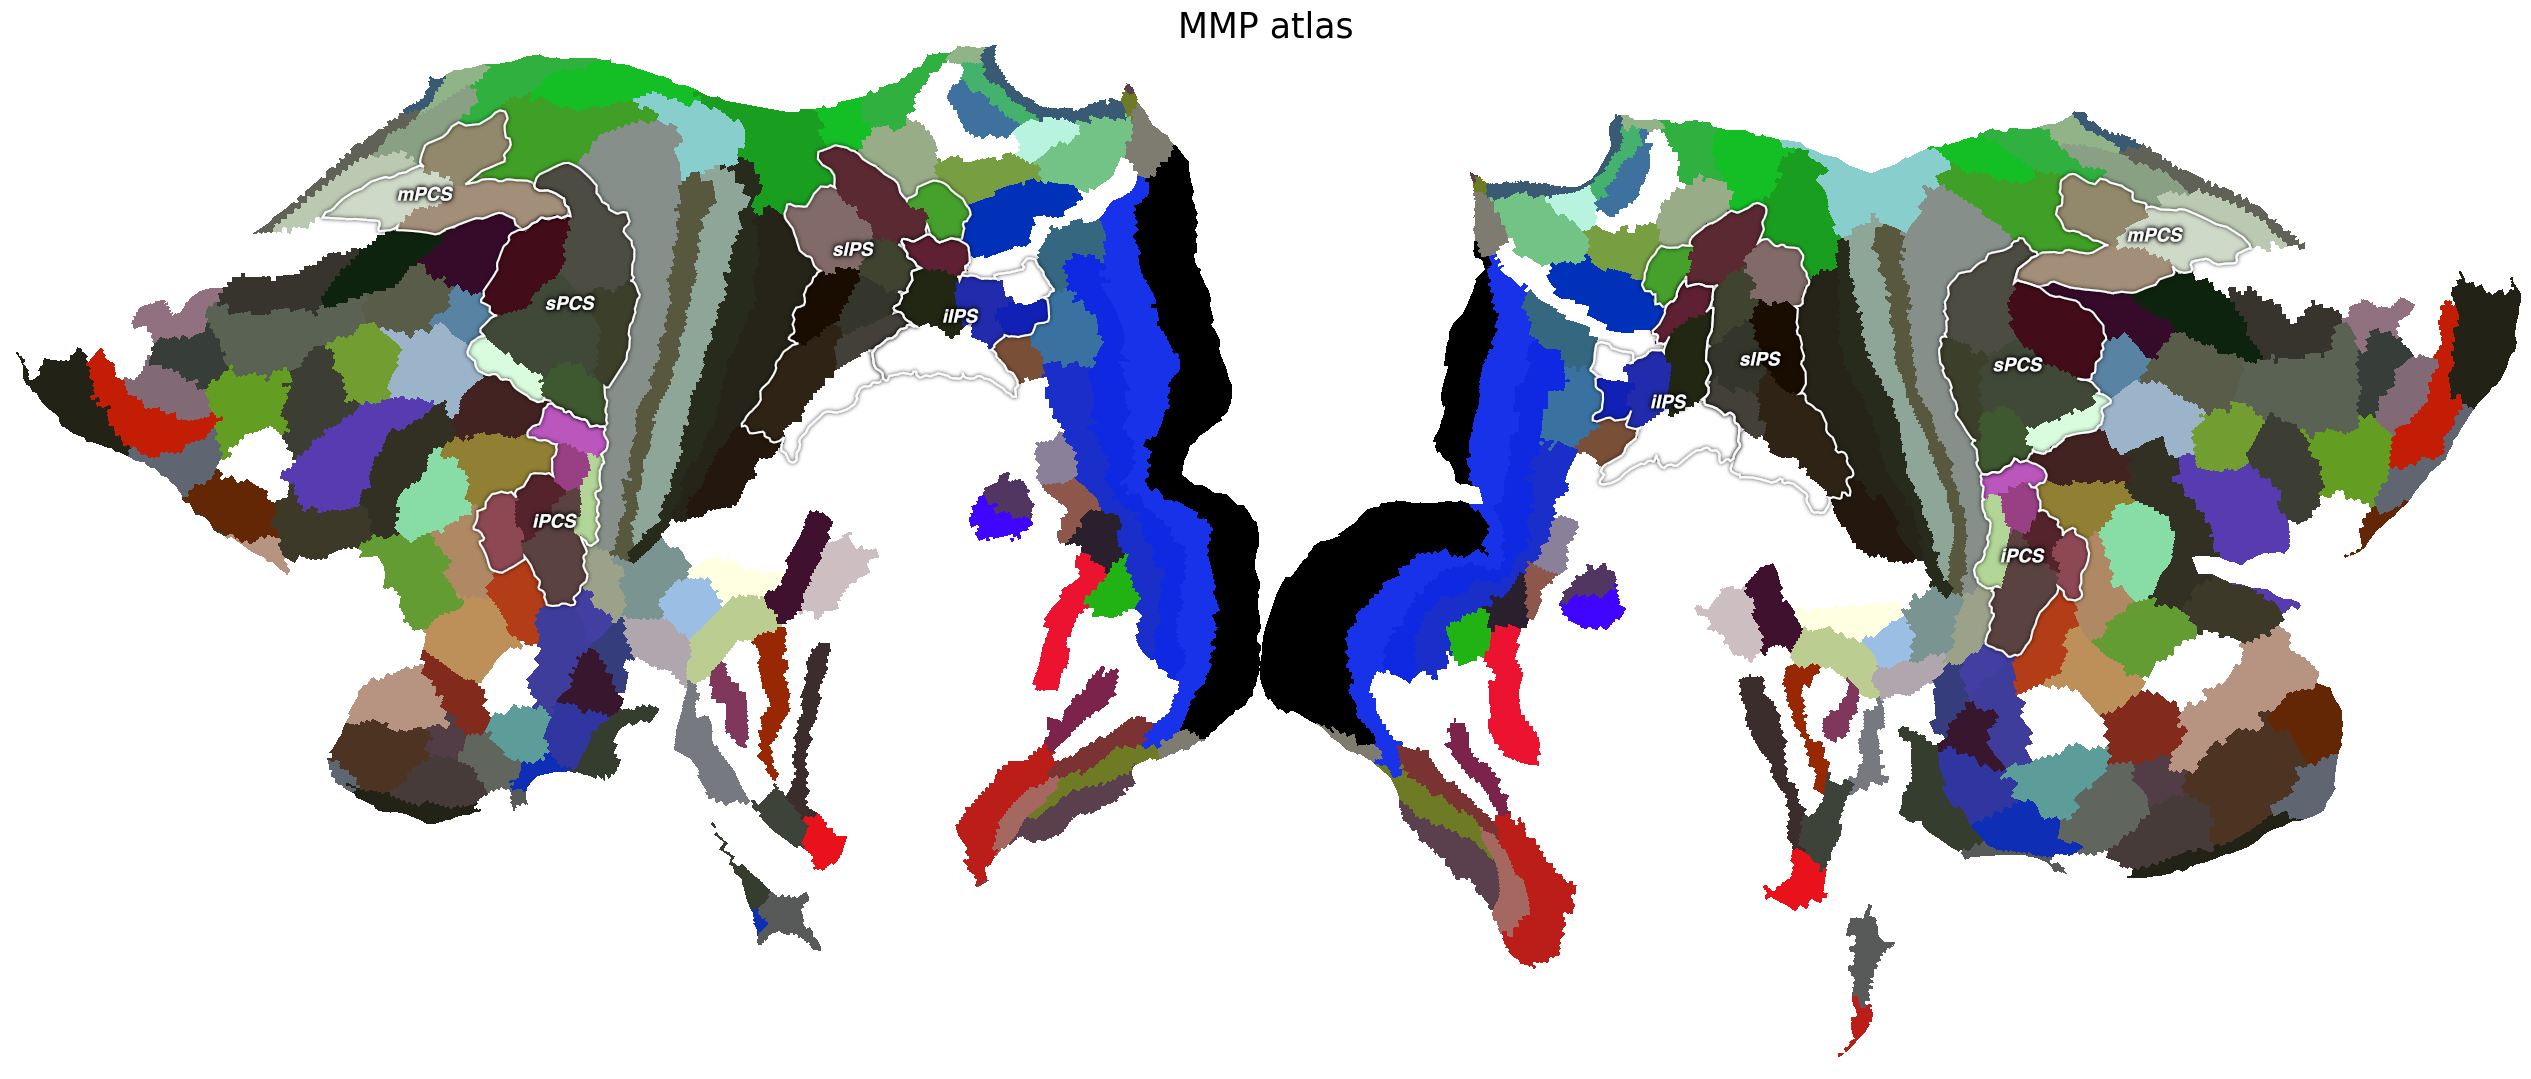

In [9]:
# plot mmp 
vertex_data = cortex.Vertex(np.array(mmp_final_df['roi_id']), pycortex_subject, cmap='HCP_MMP1')

cortex.quickshow(vertex_data, with_colorbar=False)
plt.title("MMP atlas", fontsize=25)
plt.savefig('/Users/uriel/Downloads/mmp_atlas.pdf')
plt.show()

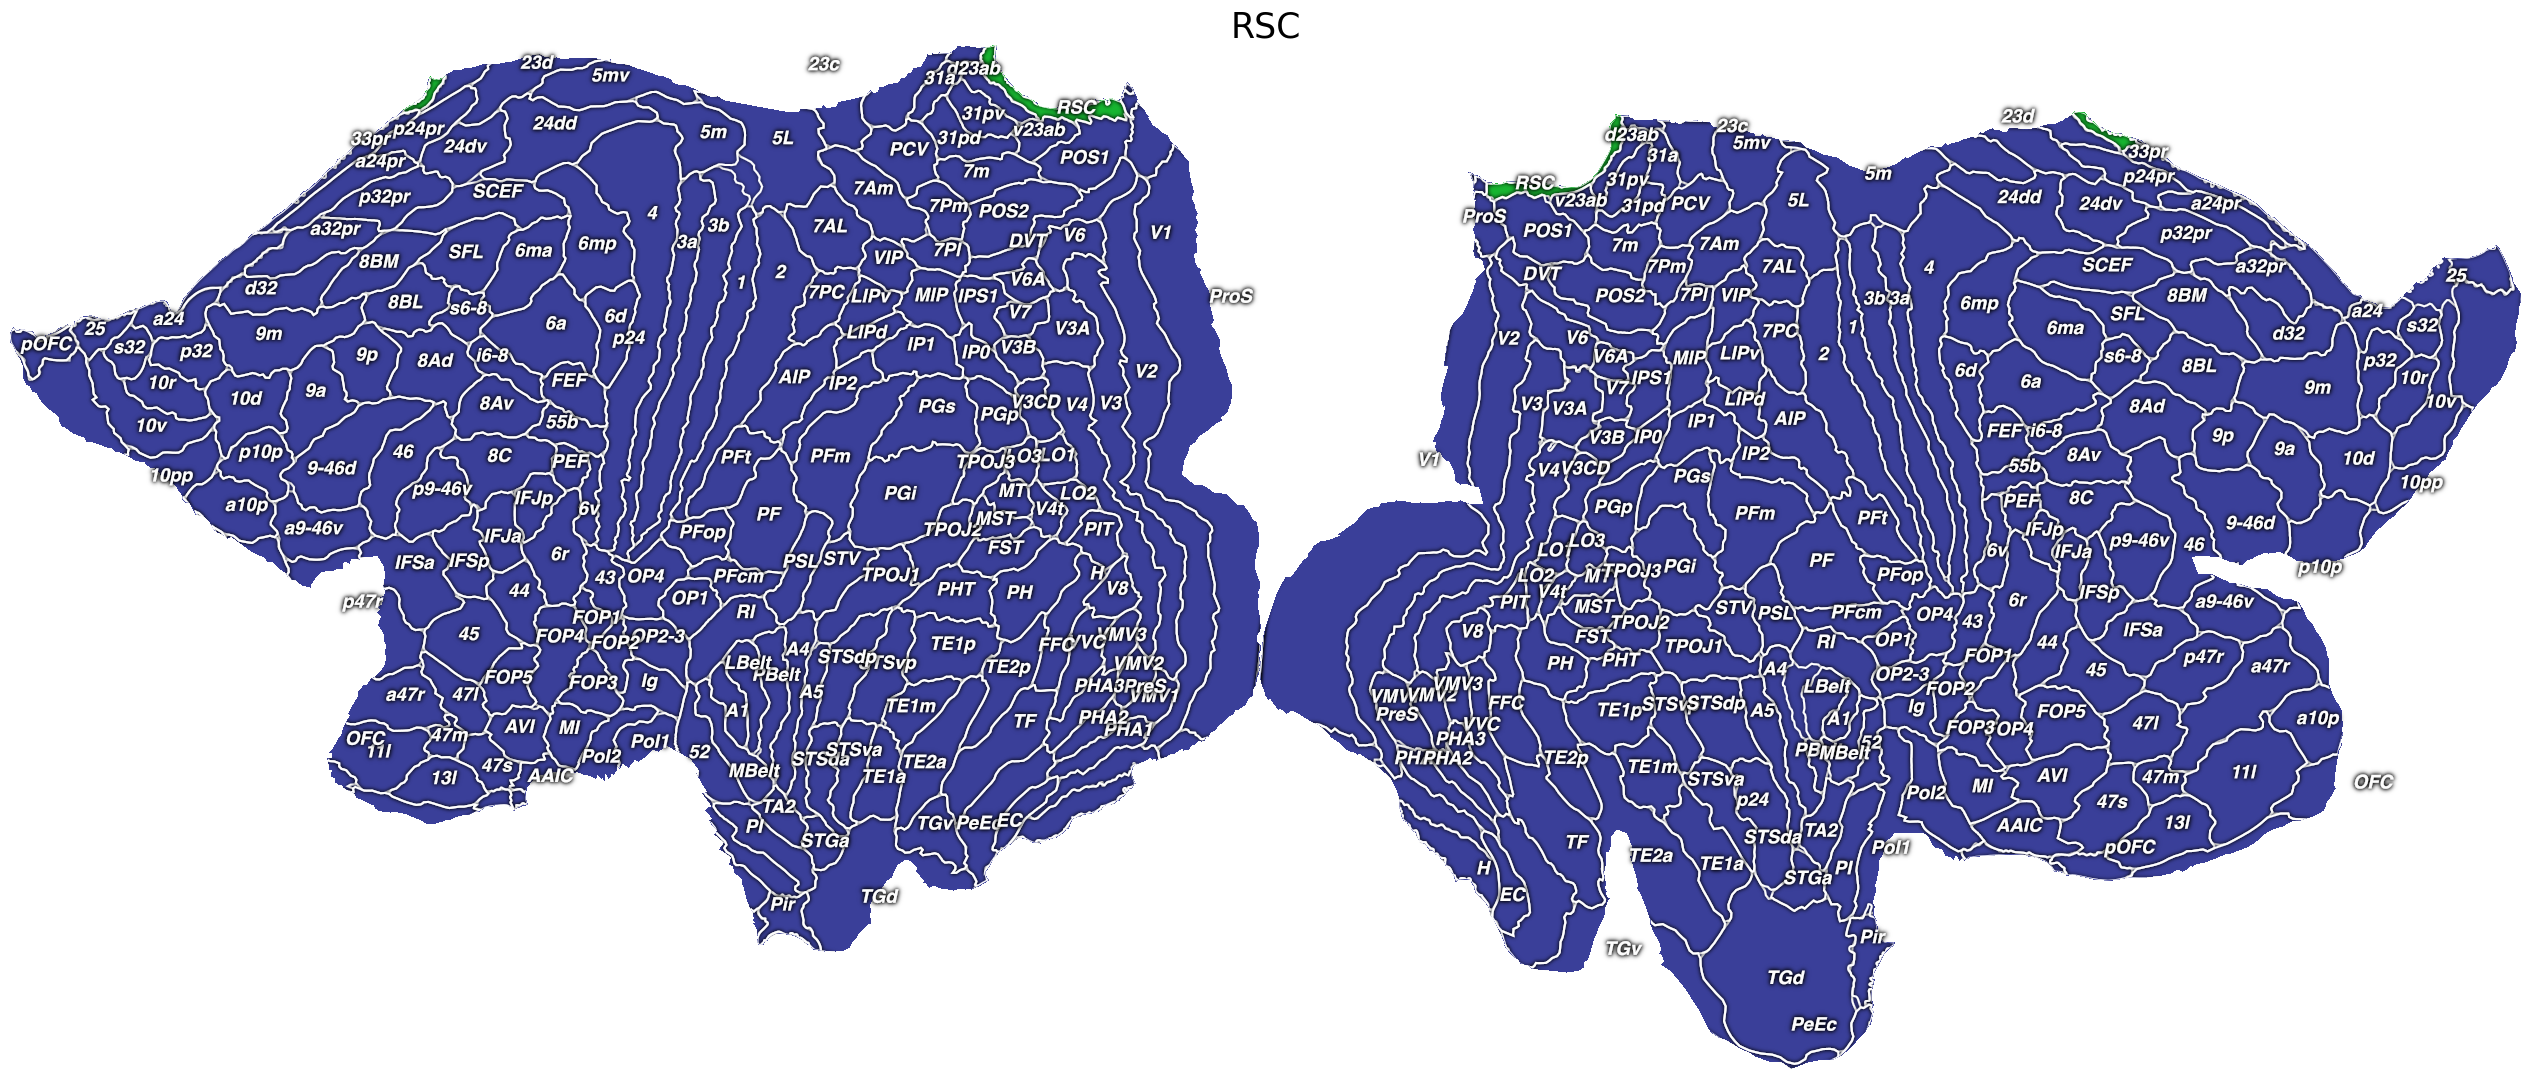

In [10]:
# plot any area you want 
roi_name = 'RSC'
roi_data = np.array((mmp_final_df['roi_name'] == roi_name).astype(np.int32))
vertex_data = cortex.Vertex(roi_data, pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
cortex.quickshow(vertex_data, with_colorbar=False)
plt.title('{}'.format(roi_name), fontsize=25)
plt.show()

In [52]:
# # Export rois map (comment to do only one time)
# rois_names = np.unique(mmp_final_df['roi_name'])

# for roi_name in rois_names:
#     roi_data = np.array((mmp_final_df['roi_name'] == roi_name).astype(np.int32))
#     vertex_data = cortex.Vertex(roi_data, pycortex_subject, cmap='BROYG',vmin=0,vmax=1)
#     cortex.quickshow(vertex_data, with_colorbar=False)
#     plt.title('{}'.format(roi_name),fontsize=25)
#     plt.savefig('/Users/uriel/Desktop/mmp_rois_fig/{}.pdf'.format(roi_name))


In [6]:
# make a final dict with rois masks to export it as npz
rois_names = mmp_final_df.roi_name.unique()
roi_dict = {}
for roi_name in rois_names:
    roi_data = np.array(mmp_final_df['roi_name'] == roi_name)
    roi_dict[roi_name] = roi_data



# # save the dict as npz
# rois_npz_fn = '{}/{}/mmp_atlas_rois_59k.npz'.format(pycortex_dir, pycortex_subject)
# np.savez(rois_npz_fn, **roi_dict)

In [12]:
# # add the rois to the overlay (comment to not add rois multiple time)
# overlay_fn ='{}/{}/overlays.svg'.format(pycortex_dir, pycortex_subject)
# rp = ROIpack(pycortex_subject, rois_npz_fn)
# rp.to_svg(filename=overlay_fn)

Now that we have the overlay with the ROI drawings, you need to extract the straight lines from the layers. Additionally, after verification, we have identified issues with the following areas: 'p24', 'RSC', 'V3A', 'H', 'pOFC', and 'Pir'. The next step is to correct them. The plan is to create a layer for each of these areas individually. Then, open Inkscape, vectorize these images (Path > Trace Bitmap), split the paths for each hemisphere, and add them to the corresponding ROI layer.

In [11]:
# # add the layer to the overlay (comment to not doing it multiple times)
# rois_to_add = ['p24', 'RSC', 'V3A', 'H', 'pOFC', 'Pir']
# for roi_name in rois_to_add : 
#     roi_data = np.array((mmp_final_df['roi_name'] == roi_name).astype(np.int32))
#     vertex_data = cortex.Vertex(roi_data, pycortex_subject, cmap='flag', vmin=0, vmax=1)
#     cortex.utils.add_roi(data = vertex_data, name = roi_name, open_inkscape = False, add_path = False)

# Verifications

In [9]:
# Import rois masks from Pycortex
roi_verts = cortex.get_roi_verts(subject=pycortex_subject, mask=True)

In [14]:
# Make a function to compare dictionaire
def comp_dicts(dict1, dict2):
    keys = set(dict1.keys()) | set(dict2.keys())
    result = {}
    for key in keys:
        values1 = dict1.get(key, np.array([]))
        values2 = dict2.get(key, np.array([]))
        if isinstance(values1, np.ndarray) and isinstance(values2, np.ndarray):
            
            difference_count = np.sum(values1 != values2)
            result[key] = difference_count
        else:
            result[key] = 1 if values1 != values2 else 0
    return result

In [17]:
# Compare the ROI masks obtained with cortex.get_roi_verts and those from the NPZ mask
diff_rois = comp_dicts(roi_verts, roi_dict)

In [19]:
# Make a figure with the difference for each rois 
keys = list(diff_rois.keys())
values = list(diff_rois.values())


num_subplots = 8
keys_split = [keys[i:i + len(keys) // num_subplots] for i in range(0, len(keys), len(keys) // num_subplots)]
values_split = [values[i:i + len(values) // num_subplots] for i in range(0, len(values), len(values) // num_subplots)]


fig = make_subplots(rows=num_subplots, cols=1,
                    vertical_spacing=0.1, horizontal_spacing=1)


for i in range(num_subplots):
    fig.add_trace(go.Bar(x=keys_split[i], 
                         y=values_split[i], 
                         marker_color='purple'), 
                  row=i+1, col=1)



fig.update_layout(template='simple_white',
                  title='Number of different vertex include in rois between pycortex and npz',
                  xaxis_title='ROIs',
                  yaxis_title='Number of Differencent vertex',
                  showlegend=False, 
                  height=1800, 
                  width=800,
                  xaxis=dict(title=dict(standoff=1560)),  
                  yaxis=dict(title=dict(standoff=10)))  


# fig.write_image('/Users/uriel/Downloads/roi_dif.pdf')
# fig.show()


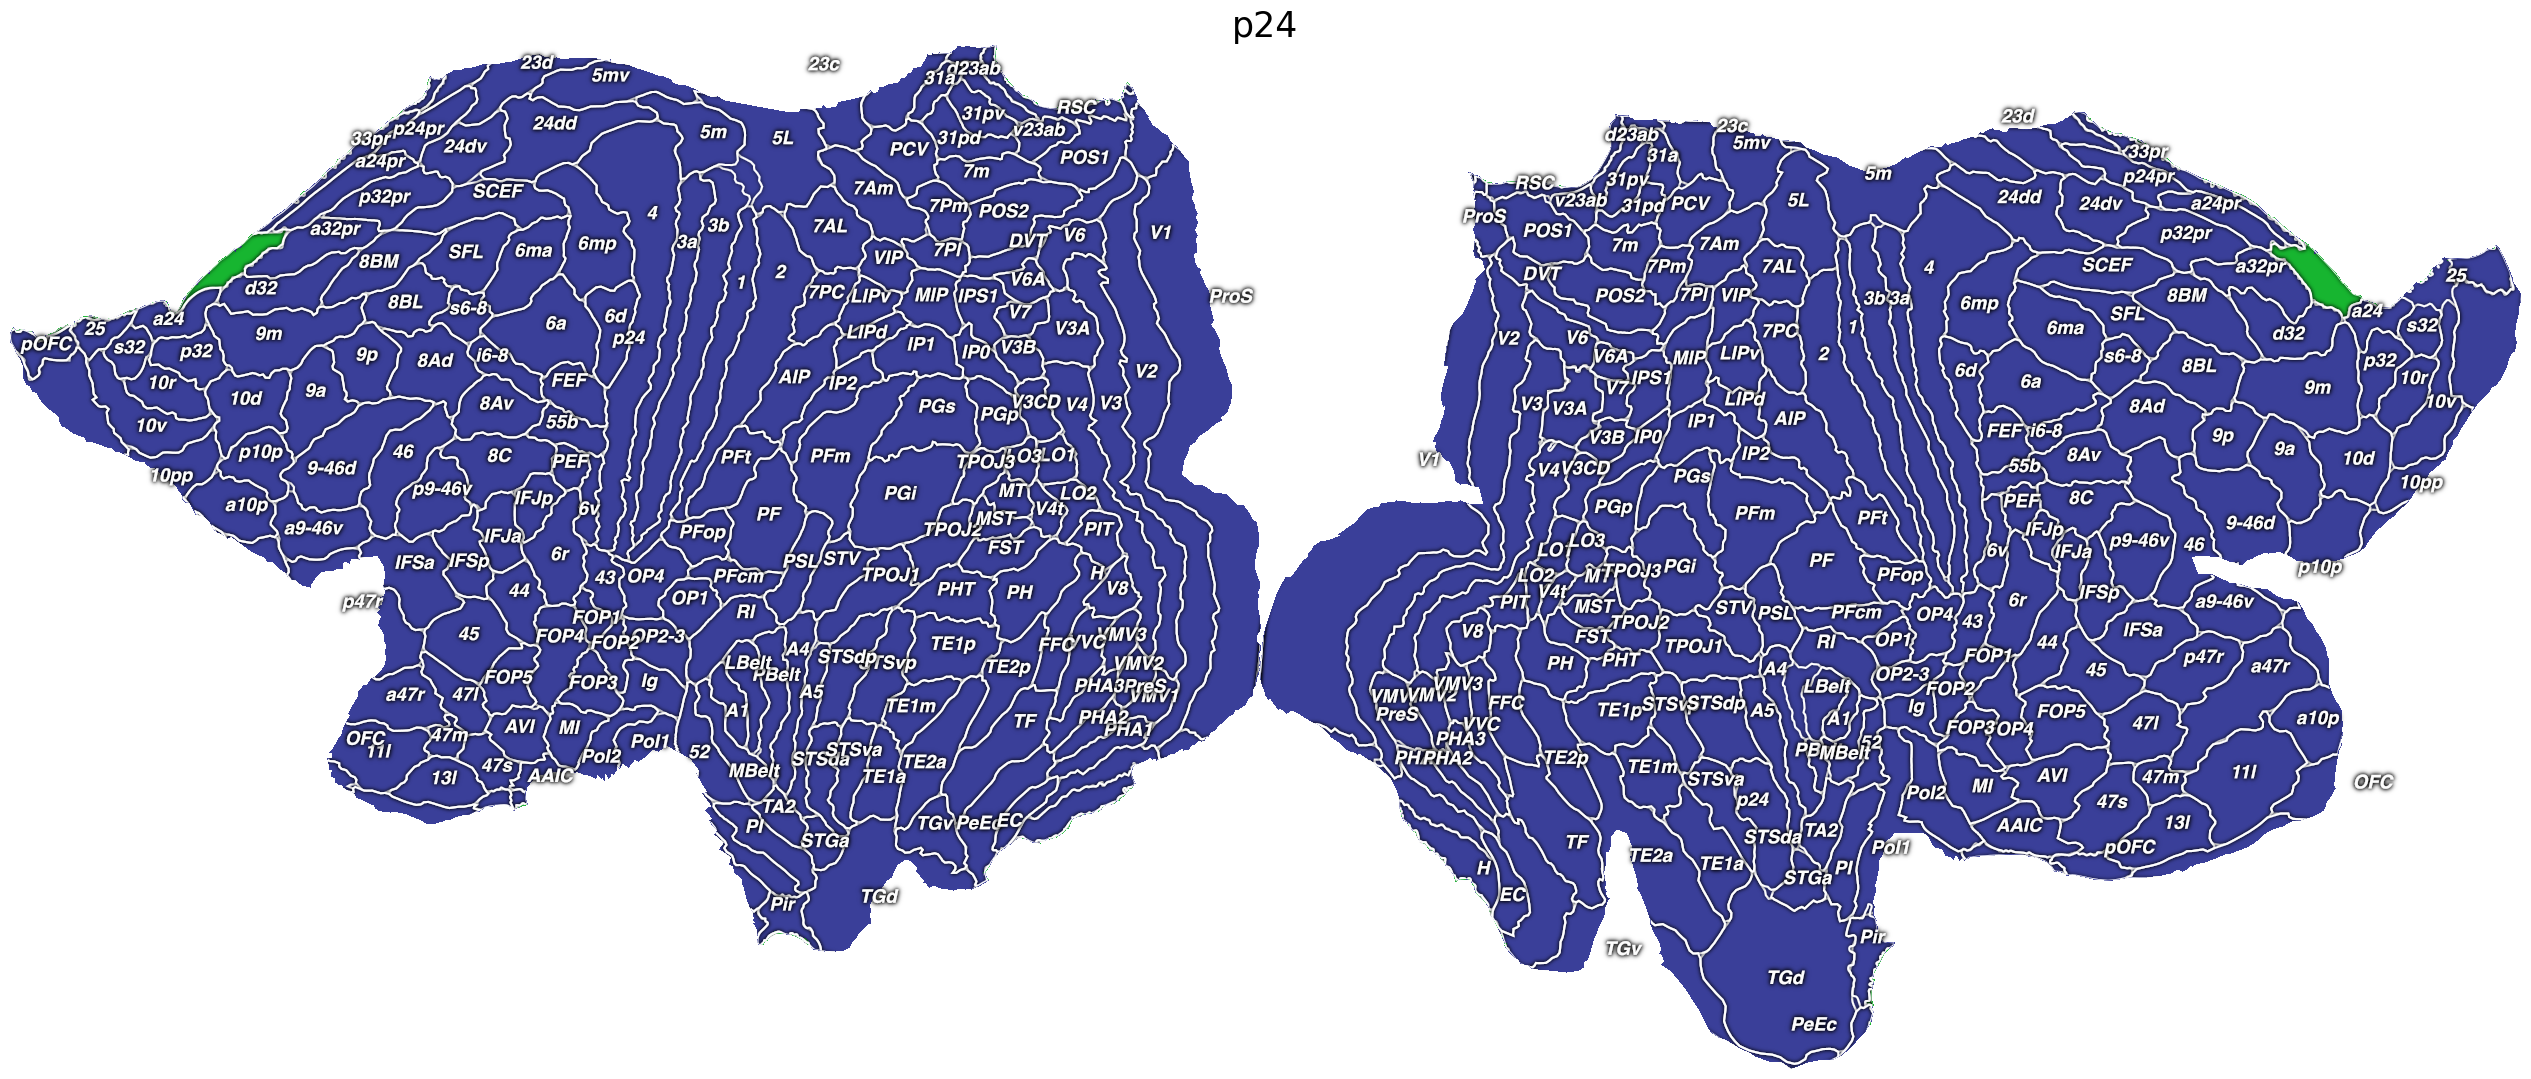

In [20]:
# plot any area you want in the areas import from pycortex
roi_name = 'p24'
roi_data = np.array((roi_verts[roi_name]).astype(np.int32))
vertex_data = cortex.Vertex(roi_data, pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
cortex.quickshow(vertex_data, with_colorbar=False)
plt.title('{}'.format(roi_name), fontsize=25)
plt.show()

In [83]:
# # export pycortex imported roi 
# rois_names =['V3A','H','pOFC','Pir']
# for roi_name in rois_names:

#     roi_data = np.array((roi_verts[roi_name]).astype(np.int32))
#     vertex_data = cortex.Vertex(roi_data, pycortex_subject, cmap='BROYG', vmin=0, vmax=1)
#     cortex.quickshow(vertex_data, with_colorbar=False)
#     plt.title('{}'.format(roi_name), fontsize=25)
#     plt.savefig('/Users/uriel/Desktop/mmp_rois_fig_pycortex/{}.pdf'.format(roi_name))